In [1]:
import ete2
import skbio
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

No module named MySQLdb
No module named PyQt4.QtGui
Populating the interactive namespace from numpy and matplotlib


 MySQLdb module could not be loaded
Treeview module could not be loaded


## Load a tree

In [2]:
# it'd be nice if this expandvars call happened interally
from os.path import expandvars
et = ete2.Tree(expandvars('$HOME/data/gg_13_8_otus/trees/61_otus.tree'))
st = skbio.TreeNode.read(expandvars('$HOME/data/gg_13_8_otus/trees/61_otus.tree'))

## repr the tree

In [3]:
et

Tree node 'NoName' (0x10a9e7b1)

In [4]:
st

<TreeNode, name: unnamed, internal node count: 20, tips count: 22>

In [5]:
print et


                  /-801940
               /-|
            /-|   \-3825327
           |  |
         /-|   \-1928988
        |  |
        |  |   /-4455990
      /-|   \-|
     |  |      \-1128285
     |  |
   /-|   \-823009
  |  |
  |  |   /-3770699
  |   \-|
  |      \-426860
  |
  |      /-3761685
  |   /-|
--|  |   \-4423155
  |  |
  |  |               /-4391683
  |  |              |
  |  |            /-|   /-4336814
  |  |           |  |  |
  |  |           |  |  |         /-3190878
  |  |           |   \-|      /-|
  |  |           |     |   /-|   \-4452949
   \-|           |     |  |  |
     |         /-|      \-|   \-4251079
     |        |  |        |
     |        |  |        |   /-2107103
     |        |  |         \-|
     |      /-|  |            \-4363563
     |     |  |  |
     |     |  |   \-229854
     |   /-|  |
     |  |  |   \-4459468
     |  |  |
      \-|   \-696036
        |
        |   /-3779572
         \-|
            \-4363260


In [6]:
et.describe()

Number of leaf nodes:	22
Number of internal nodes:	43
Rooted:	Yes
Most distant node:	3770699
Max. distance:	2.600350


In [7]:
print st

((((((801940:0.16748,3825327:0.36897):0.07831,1928988:0.27799)'p__Crenarchaeota':0.04405,(4455990:0.14403,1128285:0.14461):0.16704):0.01855,823009:0.3881):0.01587,(3770699:0.60035,426860:0.28962)'c__[Parvarchaea]':0.07841)'k__Archaea':0.31772,((3761685:0.18326,4423155:0.5605):0.07543,(((((4391683:0.26125,(4336814:0.35428,(((3190878:0.36049,4452949:0.08994):0.12795,4251079:0.19473):0.02384,(2107103:0.54203,4363563:0.46236):0.06044):0.20722):0.05703):0.08253,229854:0.24026):0.02393,4459468:0.37727):0.01293,696036:0.63811):0.0212,(3779572:0.1464,4363260:0.11356)0.081:0.30451):0.09868):0.15861);



## Traversing the tree and time it

In [8]:
%%timeit 
# load the tree on each loop to avoid caching of results
ete2.Tree(expandvars('$HOME/data/gg_13_8_otus/trees/85_otus.tree')).traverse("postorder")

10 loops, best of 3: 105 ms per loop


In [9]:
%%timeit 
# load the tree on each loop to avoid caching of results
skbio.TreeNode.read(expandvars('$HOME/data/gg_13_8_otus/trees/85_otus.tree')).postorder()

10 loops, best of 3: 108 ms per loop


## Implement and compute PD

Phylogenetic Diversity (PD) is the amount of branch length in a phylogenetic tree that is observed in a given biological community. It is a phylogenetic estimator of community richness. I describe it in some more detail in [IAB](http://nbviewer.ipython.org/github/gregcaporaso/An-Introduction-To-Applied-Bioinformatics/blob/0.1.0/applications/biological-diversity.ipynb#Phylogenetic-Diversity-(PD)).

In [10]:
from random import shuffle
tip_names = [t.name for t in st.tips()]
shuffle(tip_names)
observed_tips = tip_names[:10]

In [11]:
%timeit et.get_leaves_by_name('801940')[0]

10000 loops, best of 3: 70.2 µs per loop


In [12]:
%timeit st.find('801940')

The slowest run took 47.37 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.68 µs per loop


In [13]:
%timeit et.get_leaves_by_name('801940')[0].get_ancestors()

10000 loops, best of 3: 74.3 µs per loop


In [14]:
%timeit st.find('801940').ancestors()

The slowest run took 4.45 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 5.19 µs per loop


20
5.45864


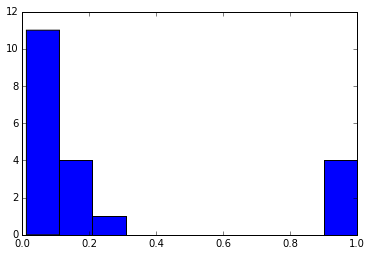

In [15]:
def et_pd(tree, observed_tips):
    observed_nodes = set()
    for tip_name in observed_tips:
        observed_nodes |= set(tree.get_leaves_by_name(tip_name)[0].get_ancestors())
    pd = sum([o.dist for o in observed_nodes])
    ds = [(o.dist, o.name) for o in observed_nodes]
    ds.sort()
    print len(ds)
    return ds, pd
ds, pd = et_pd(et, observed_tips)
print pd
_ = plt.hist([e[0] for e in ds])

19
1.89882


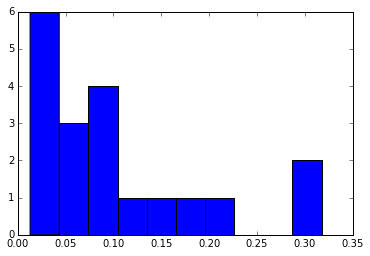

In [16]:
def sk_pd(tree, observed_tips):
    observed_nodes = set()
    for tip_name in observed_tips:
        observed_nodes |= set(tree.find(tip_name).ancestors())
    pd = sum([o.length for o in observed_nodes if o.length != None])
    ds = [(o.length, o.name) for o in observed_nodes if o.length != None]
    print len(ds)
    return ds, pd
ds, pd = sk_pd(st, observed_tips)
print pd
_ = plt.hist([e[0] for e in ds])

## **Question**: where are all of the branch lengths of 1.0 coming from in the ete2 tree??

In [17]:
# let's just parse the floats from the newick tree now and see what we get...
import re
s = open(expandvars("$HOME/data/gg_13_8_otus/trees/61_otus.tree")).read()
print s

((((((801940:0.16748,3825327:0.36897):0.07831,1928988:0.27799)'p__Crenarchaeota':0.04405,(4455990:0.14403,1128285:0.14461):0.16704):0.01855,823009:0.3881):0.01587,(3770699:0.60035,426860:0.28962)'c__[Parvarchaea]':0.07841)'k__Archaea':0.31772,((3761685:0.18326,4423155:0.5605):0.07543,(((((4391683:0.26125,(4336814:0.35428,(((3190878:0.36049,4452949:0.08994):0.12795,4251079:0.19473):0.02384,(2107103:0.54203,4363563:0.46236):0.06044):0.20722):0.05703):0.08253,229854:0.24026):0.02393,4459468:0.37727):0.01293,696036:0.63811):0.0212,(3779572:0.1464,4363260:0.11356)0.081:0.30451):0.09868):0.15861);


[0.01293, 0.01587, 0.01855, 0.0212, 0.02384, 0.02393, 0.04405, 0.05703, 0.06044, 0.07543, 0.07831, 0.07841, 0.08253, 0.08994, 0.09868, 0.11356, 0.12795, 0.14403, 0.14461, 0.1464, 0.15861, 0.16704, 0.16748, 0.18326, 0.19473, 0.20722, 0.24026, 0.26125, 0.27799, 0.28962, 0.30451, 0.31772, 0.35428, 0.36049, 0.36897, 0.37727, 0.3881, 0.46236, 0.54203, 0.5605, 0.60035, 0.63811]
42 0.01293 0.162825 0.63811


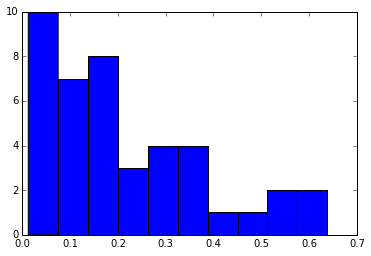

In [18]:
lengths = map(float,[e[1:] for e in re.findall(':\d\.\d+', s)])
lengths.sort()
print lengths
print len(lengths), np.min(lengths), np.median(lengths), np.max(lengths)
_ = plt.hist(lengths)

[0.01293, 0.01587, 0.01855, 0.0212, 0.02384, 0.02393, 0.04405, 0.05703, 0.06044, 0.07543, 0.07831, 0.07841, 0.08253, 0.08994, 0.09868, 0.11356, 0.12795, 0.14403, 0.14461, 0.1464, 0.15861, 0.16704, 0.16748, 0.18326, 0.19473, 0.20722, 0.24026, 0.26125, 0.27799, 0.28962, 0.30451, 0.31772, 0.35428, 0.36049, 0.36897, 0.37727, 0.3881, 0.46236, 0.54203, 0.5605, 0.60035, 0.63811]
42 0.01293 0.162825 0.63811


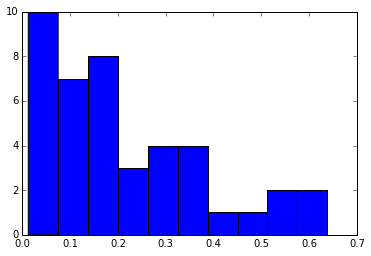

In [19]:
# and compare that with the skbio lengths
lengths = [n.length for n in st.postorder() if n.length is not None]
lengths.sort()
print lengths
print len(lengths), np.min(lengths), np.median(lengths), np.max(lengths)
_ = plt.hist(lengths)

[0.01293, 0.01587, 0.01855, 0.0212, 0.02384, 0.02393, 0.05703, 0.06044, 0.07543, 0.07831, 0.08253, 0.08994, 0.09868, 0.11356, 0.12795, 0.14403, 0.14461, 0.1464, 0.15861, 0.16704, 0.16748, 0.18326, 0.19473, 0.20722, 0.24026, 0.26125, 0.27799, 0.28962, 0.30451, 0.35428, 0.36049, 0.36897, 0.37727, 0.3881, 0.46236, 0.54203, 0.5605, 0.60035, 0.63811, 1.0, 1.0, 1.0, 1.0]
43 0.01293 0.18326 1.0


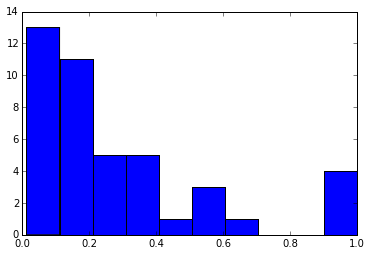

In [20]:
# and the ete2 lengths
lengths = [n.dist for n in et.traverse("postorder")]
lengths.sort()
print lengths
print len(lengths), np.min(lengths), np.median(lengths), np.max(lengths)
_ = plt.hist(lengths)

This is bad... it looks like ete2 is not recognizing the node names, but silently converting them to ``1.0``. This should raise an exception as it can give very misleading results (as is the case here).

Loading with ``format=1`` gets us closer, but there is one label that is still being converted to ``1.0``. This is still very bad, but there also may be an issue with that node in the tree... Is the name of the node really supposed to be ``0.081``?

In [21]:
et1 = ete2.Tree(expandvars('$HOME/data/gg_13_8_otus/trees/61_otus.tree'), format=1)

20
3.82041


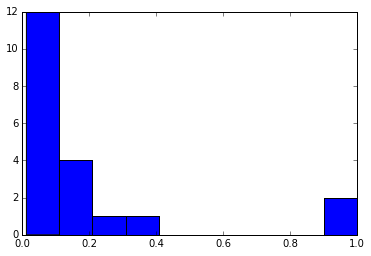

In [22]:
ds, pd = et_pd(et1, observed_tips)
print pd
_ = plt.hist([e[0] for e in ds])